# K-Means

K-means is an unsupervised-learning algorithm which separates the data into $k$ different clusters. The algorithm works by minimizing the sum of squares of the samples within each cluster. A cluster $\it{S}_j$ is represented by its centroid $m_j$. A certain sample $x_i$ belongs to a cluster $\it{S}_j$ if $m_j$ is the closest centroid among all centroids. A cluster is conformed then by:
$$
\it{S}_j = \{x_i : \|x_i - m_j\|_2 < \|x_i - m_p\|_2 \forall p, 1\leq p\leq K, p \neq j\}
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append("..")
from models.k_means import KMeans
from utils.datasets import blobs_classification_dataset
from utils.visualization import plot_decision_boundary

In [2]:
%matplotlib inline

np.random.seed(1)

### Fitting 5 true clusters with different values of k

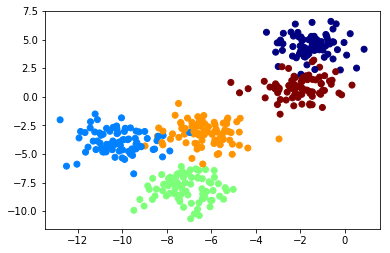

In [3]:
(x_train, y_train), (_, _) = blobs_classification_dataset(features=2, classes=5, samples=500)

# Visualize
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
plt.show()

In [4]:
# Initialize and fit the model
model3 = KMeans(k=3)
model3.fit(x_train)

Algorithm converged at iteration nº6


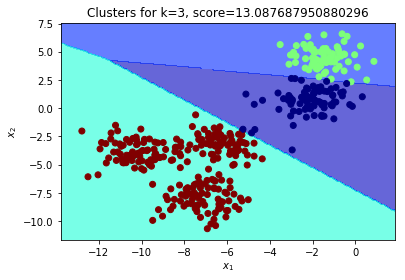

In [5]:
# Visualize decision boundary
y_hat, score = model3.predict(x_train, score=True)

ax = plot_decision_boundary(model3.predict,
                            x_range=[x_train[:, 0].min()-1, x_train[:, 0].max()+1],
                            y_range=[x_train[:, 1].min()-1, x_train[:, 1].max()+1], classes=5)
ax.scatter(x_train[:, 0], x_train[:, 1], c=model3.predict(x_train), cmap='jet', label='True classes')
plt.title("Clusters for k={}, score={}".format(3, score))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

### Define cross-validation to asses the quality of k
Due to the random initialization, k-means does not always converge to the same solution for the same data and number of clusters to. To more confidently asses the quality of the hyper-parameter k we can use cross-validation.

In [6]:
def cross_validate(model, X, f=5):
    X_fold = X
    pivot = int(X_fold.shape[0]/f)
    cum_score = 0
    for _ in range(f):
        # Always take firt fold as test
        x_test = X_fold[:pivot, :]
        x_train = X_fold[pivot:, :]
        
        # fit the model
        model.fit(X=x_train, verbose=False)
        y_hat, score = model.predict(x_test, score=True)
        
        cum_score += score
        
        X_fold = np.concatenate((x_train, x_test))
        
    return cum_score/f

In [7]:
score = cross_validate(model3, x_train)
print("Validated score for k=3, score={}".format(score))

Validated score for k=3, score=13.336161373395026


### Search for optimum value of k

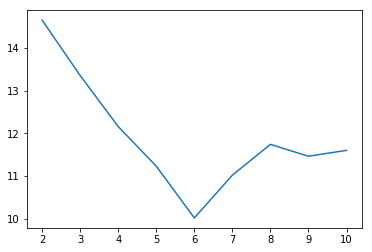

In [8]:
K = [2, 3, 4, 5, 6, 7, 8, 9, 10]

scores = []
for k in K:
    model = KMeans(k=k)
    scores.append(cross_validate(model, x_train))
    
    
# Display results
plt.plot(K, scores)
plt.show()